# Google Trends Time Series Analysis
This notebook analyses interest over time for selected keywords using Google Trends data via the `pytrends` API.

**Author**: Sheryll Dumapal  
**License**: Personal and non-commercial use only. © 2025 Sheryll Dumapal. See LICENSE file for details.

## Setup
Install required libraries if they are not already installed.

In [ ]:
!pip install pytrends

## Importing Libraries

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pytrends.request import TrendReq
import platform

Python version: 3.12.2


## Connect to Google Trends

In [19]:
# Initialize pytrends object with German settings
pytrends = TrendReq(hl='de-DE', tz=60)

## Define Search Keywords

In [20]:
# Creating a list of keywords to search 
kw_list = ['chatgpt','ai','deepseek']

# Retrieve Data Trend

In [21]:
pytrends.build_payload(kw_list, 
                       cat=0, 
                       timeframe='today 5-y',
                       geo='DE',
                       gprop='')

df_trend = pytrends.interest_over_time()
print(df_trend.info())
print(df_trend.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-05-17 to 2025-05-18
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   chatgpt    262 non-null    int64
 1   ai         262 non-null    int64
 2   deepseek   262 non-null    int64
 3   isPartial  262 non-null    bool 
dtypes: bool(1), int64(3)
memory usage: 8.4 KB
None
            chatgpt  ai  deepseek  isPartial
date                                        
2020-05-17        0   3         0      False
2020-05-24        0   3         0      False
2020-05-31        0   3         0      False
2020-06-07        0   3         0      False
2020-06-14        0   3         0      False


/opt/anaconda3/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


## Data Quality Check

In [7]:
print(df_trend.describe())
print(df_trend.isnull().sum())

          chatgpt          ai    deepseek
count  262.000000  262.000000  262.000000
mean    18.267176   16.473282    0.484733
std     23.263549   14.294295    3.262136
min      0.000000    3.000000    0.000000
25%      0.000000    4.000000    0.000000
50%      0.000000    8.000000    0.000000
75%     30.000000   29.000000    0.000000
max    100.000000   63.000000   49.000000
chatgpt      0
ai           0
deepseek     0
isPartial    0
dtype: int64


## Visualise Interest Over Time

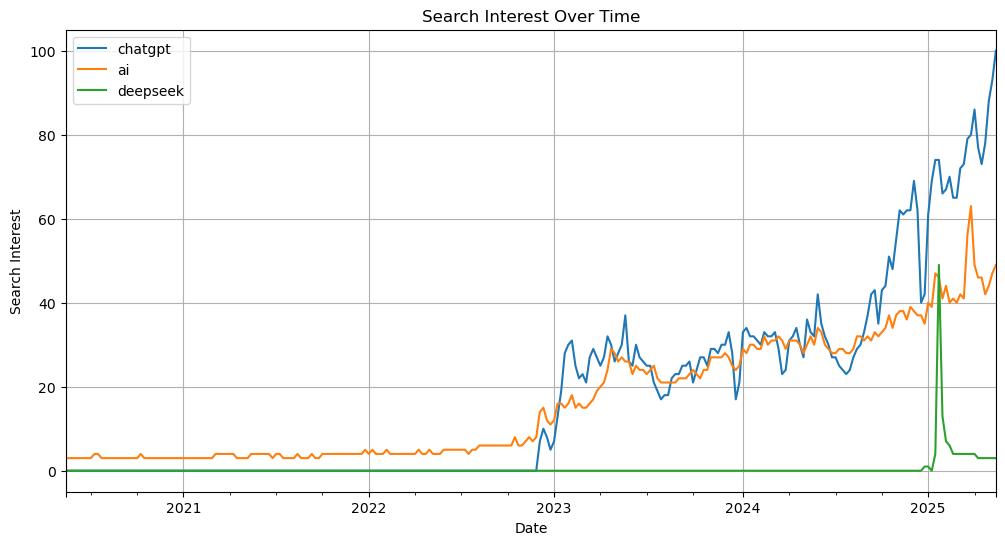

In [8]:
df_trend[kw_list].plot(figsize=(12,6), title='Search Interest Over Time')
plt.ylabel('Search Interest')
plt.xlabel('Date')
plt.grid(True)
plt.show()

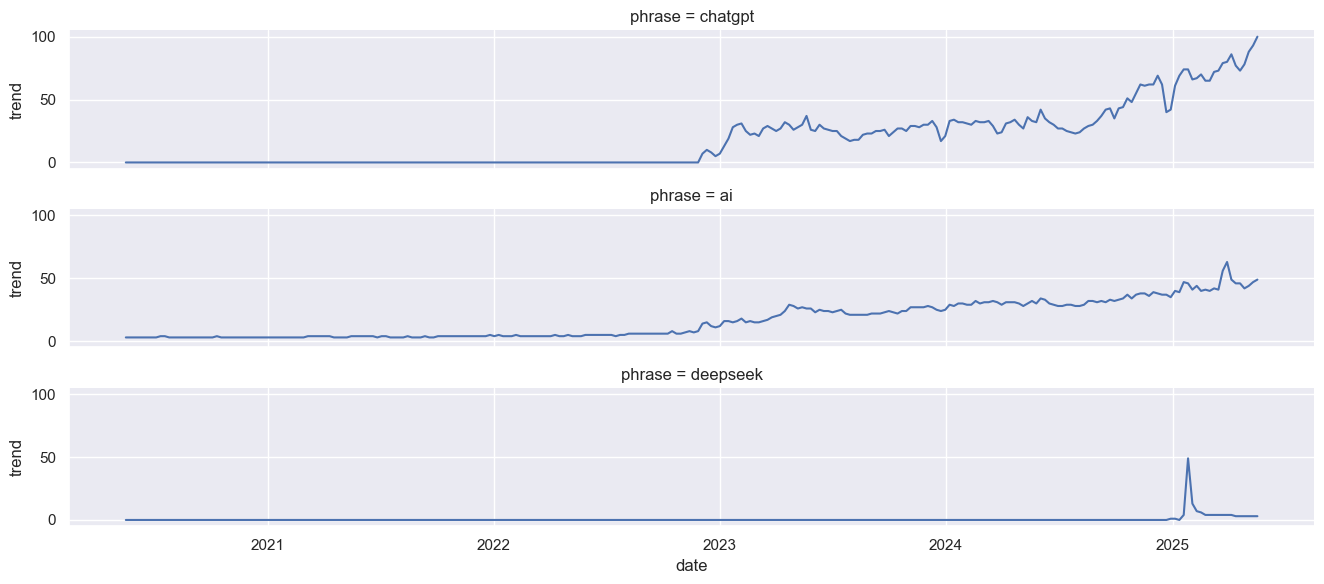

In [14]:
# Plotsize for the graphs 
sns.set(rc={'figure.figsize':(10,5)})

plot_data = df_trend.iloc[:, 0:len(df_trend.columns)-1]
plot_data = plot_data.reset_index() \
    .melt(id_vars='date', 
          var_name='phrase', 
          value_name='trend')

# Plot 
g = sns.relplot(data=plot_data, 
                x='date', 
                y='trend', 
                kind='line', 
                row='phrase', 
                height=2.0, 
                aspect=6.7)

/opt/anaconda3/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


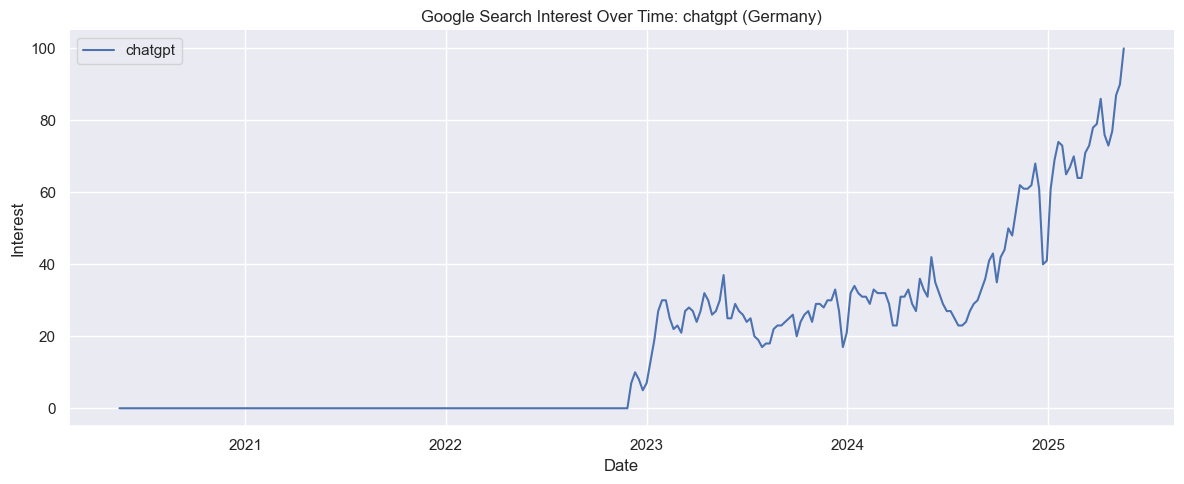

In [22]:
# Note: returns different values when the phrase is queried on its own.
kw_list = ['chatgpt']
pytrends.build_payload(kw_list,
                       cat=0,
                       timeframe='today 5-y',
                       geo='DE',
                       gprop='')

# Retrieving interest over time for the keyword
df_trend_single = pytrends.interest_over_time()

# Plot the trend
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_trend_single.iloc[:,0:1])
plt.title('Google Search Interest Over Time: chatgpt (Germany)')
plt.xlabel('Date')
plt.ylabel('Interest')
sns.despine()
plt.grid(True)
plt.tight_layout()
plt.show()


## Timeseries Decomposition
The `statsmodels` package offers tools to decompose a time series into components. This is useful for identifying trends, seasonality, and residual patterns, especially for forecasting.

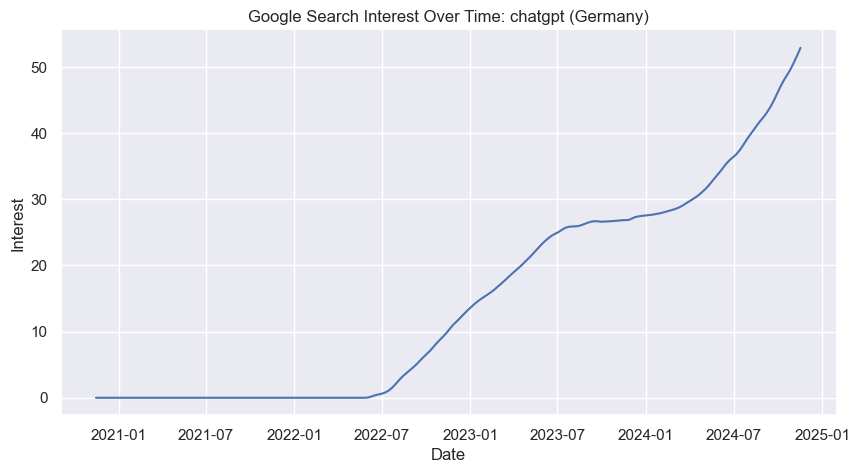

In [26]:
# Execute decompose for a time series
df = df_trend_single.iloc[:,0:1]
decompose = sm.tsa.seasonal_decompose(df,
                                      model='additive')

# Plotting the Trends 
sns.lineplot(data=decompose.trend)
plt.xlabel('Date')
plt.ylabel('Interest')
plt.title('Google Search Interest Over Time: chatgpt (Germany)')
sns.despine()
plt.show()

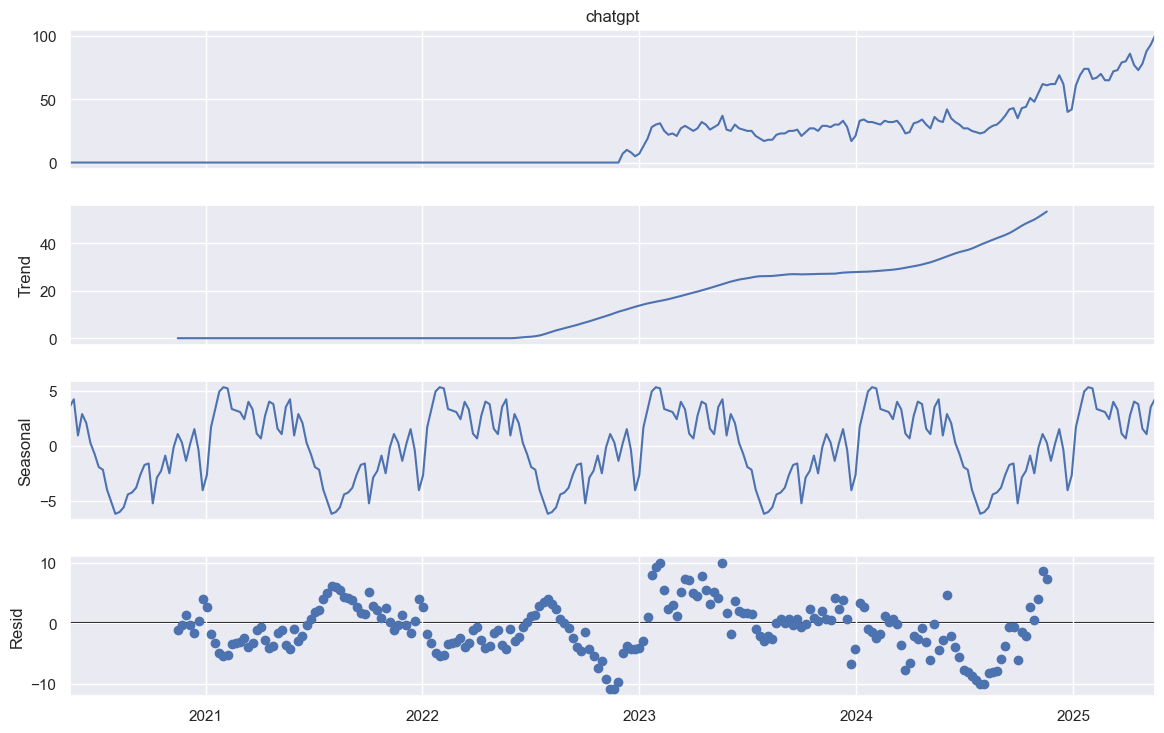

In [18]:
# Decompose a single time series (e.g., ChatGPT)
decomposition = sm.tsa.seasonal_decompose(df_trend['chatgpt'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 8)

## Summary and Next Steps
- Trends for AI-related topics show strong seasonality and growth.
- Decomposition helps identify patterns and could feed into predictive models.

**Next steps**:
- Apply decomposition to other keywords.
- Explore predictive modelling using ARIMA or Prophet.
- Combine with sentiment or volume data for deeper insight.